In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.models
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sn

In [ ]:
!pip install torchviz

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 100
learning_rate = 0.001

In [ ]:
import torch
import numpy as np
import pickle
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image

# Define function to unpickle CIFAR-10 batch files
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Define custom dataset class for CIFAR-10
class CIFAR10Dataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = self.data[idx].reshape(3, 32, 32).transpose(1, 2, 0)  # Convert to HWC format
        img = Image.fromarray(img)
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]

# Load all training batches
train_data, train_labels = [], []
for i in range(1, 6):  # CIFAR-10 has 5 training batches
    batch = unpickle(f'/content/drive/MyDrive/cifar-10-batches-py/data_batch_{i}')
    train_data.append(batch[b'data'])
    train_labels.extend(batch[b'labels'])
train_data = np.vstack(train_data).reshape(-1, 3072)
train_labels = np.array(train_labels)

# Load test batch
test_batch = unpickle('/content/drive/MyDrive/cifar-10-batches-py/test_batch')
test_data = test_batch[b'data'].reshape(-1, 3072)
test_labels = np.array(test_batch[b'labels'])

# Define transformations
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3), value=0),  # Cutout
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Create datasets
full_train_dataset = CIFAR10Dataset(train_data, train_labels, transform=transform_train)
test_dataset = CIFAR10Dataset(test_data, test_labels, transform=transform_test)

# Split training into train and validation sets
train_size, val_size = 40000, 10000
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, persistent_workers=True)

# Define class names
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')


The following code segments have been built upon the model architectures provided in https://github.com/kuangliu/pytorch-cifar

# Pre-Activation ResNet18 with Adam and ReLU

#### Create Model

In [ ]:
# Pre-activation version of the BasicBlock
class PreActBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(PreActBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)

        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False)
            )

    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))
        out += shortcut
        return out

In [ ]:
import torch.nn.functional as F
import torch.nn as nn

class PreActResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(PreActResNet, self).__init__()
        self.in_planes = 32
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.layer1 = self._make_layer(block, 32, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 64, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)
        self.dropout = nn.Dropout(0.3)  # Dropout to prevent overfitting
        self.linear = nn.Linear(256*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.dropout(out)  # Apply dropout before FC layer
        out = self.linear(out)
        return out


In [ ]:
net = PreActResNet(PreActBlock, [2,2,2,2]).to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=100)
def update_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

#### Counting the Total Number of Trainable Parameters

In [ ]:
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
pytorch_total_params

2796202

#### Model Diagram

#### Model Training

In [ ]:
total_step = len(train_loader)
curr_lr = learning_rate
best_val_acc = 0.0
patience = 30  # set the number of epochs to wait before stopping
counter = 0    # keep track of how many epochs have passed since the best validation loss was achieved

train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(100):
    # Train the model on the training set
    correct = 0
    total = 0
    train_loss = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = net(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        train_acc = correct / total
        train_loss += loss.item() * labels.size(0)

        if (i+1) % 100 == 0:
            print ("Epoch [{}/{}], Step [{}/{}] Training Loss: {:.4f}, Training Accuracy: {:.2f}%"
                  .format(epoch+1, 100, i+1, total_step, loss.item(), train_acc*100))

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Evaluate the model on the validation set
    with torch.no_grad():
        val_loss = 0
        correct = 0
        total = 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = net(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            val_loss += loss.item() * labels.size(0)

        val_loss /= len(val_loader.dataset)
        val_acc = correct / total

        print('Epoch [{}/{}], Validation Loss: {:.4f}, Validation Accuracy: {:.2f}%'.format(epoch+1, 100, val_loss, val_acc*100))

        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # Check if the current validation loss is the best so far
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            counter = 0
            torch.save(net.state_dict(), 'best_model.pth')  # save the best model so far
        else:
            counter += 1

        # Check if the patience has been exceeded
        if counter >= patience:
            print('Validation Accuracy has not improved in the last {} epochs. Stopping early...'.format(patience))
            break

    # Decay learning rate
    if (epoch+1) % 20 == 0:
        curr_lr /= 3
        update_lr(optimizer, curr_lr)

Epoch [1/100], Step [100/625] Training Loss: 1.8620, Training Accuracy: 20.59%
Epoch [1/100], Step [200/625] Training Loss: 1.7419, Training Accuracy: 25.19%
Epoch [1/100], Step [300/625] Training Loss: 1.6751, Training Accuracy: 28.32%
Epoch [1/100], Step [400/625] Training Loss: 1.5377, Training Accuracy: 31.28%
Epoch [1/100], Step [500/625] Training Loss: 1.4931, Training Accuracy: 33.95%
Epoch [1/100], Step [600/625] Training Loss: 1.2796, Training Accuracy: 36.21%
Epoch [1/100], Validation Loss: 1.3531, Validation Accuracy: 49.48%
Epoch [2/100], Step [100/625] Training Loss: 1.3046, Training Accuracy: 50.64%
Epoch [2/100], Step [200/625] Training Loss: 1.1875, Training Accuracy: 52.34%
Epoch [2/100], Step [300/625] Training Loss: 1.5002, Training Accuracy: 53.54%
Epoch [2/100], Step [400/625] Training Loss: 1.0369, Training Accuracy: 54.20%
Epoch [2/100], Step [500/625] Training Loss: 1.0477, Training Accuracy: 55.33%
Epoch [2/100], Step [600/625] Training Loss: 0.9012, Training A

In [ ]:
# create a dictionary with the lists and their names as keys
data = {'train_loss': train_losses, 'train_acc': train_accs, 'val_loss': val_losses, 'val_acc': val_accs}

# convert the dictionary to a DataFrame
df = pd.DataFrame(data)

# save the DataFrame as a CSV file
df.to_csv('preact_relu_adam.csv', index=False)

### Model Testing

In [ ]:
net.eval()
y_pred = []
y_true = []
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_pred += predicted.cpu().numpy().tolist()
        y_true += labels.cpu().numpy().tolist()

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

Accuracy of the model on the test images: 90.14 %


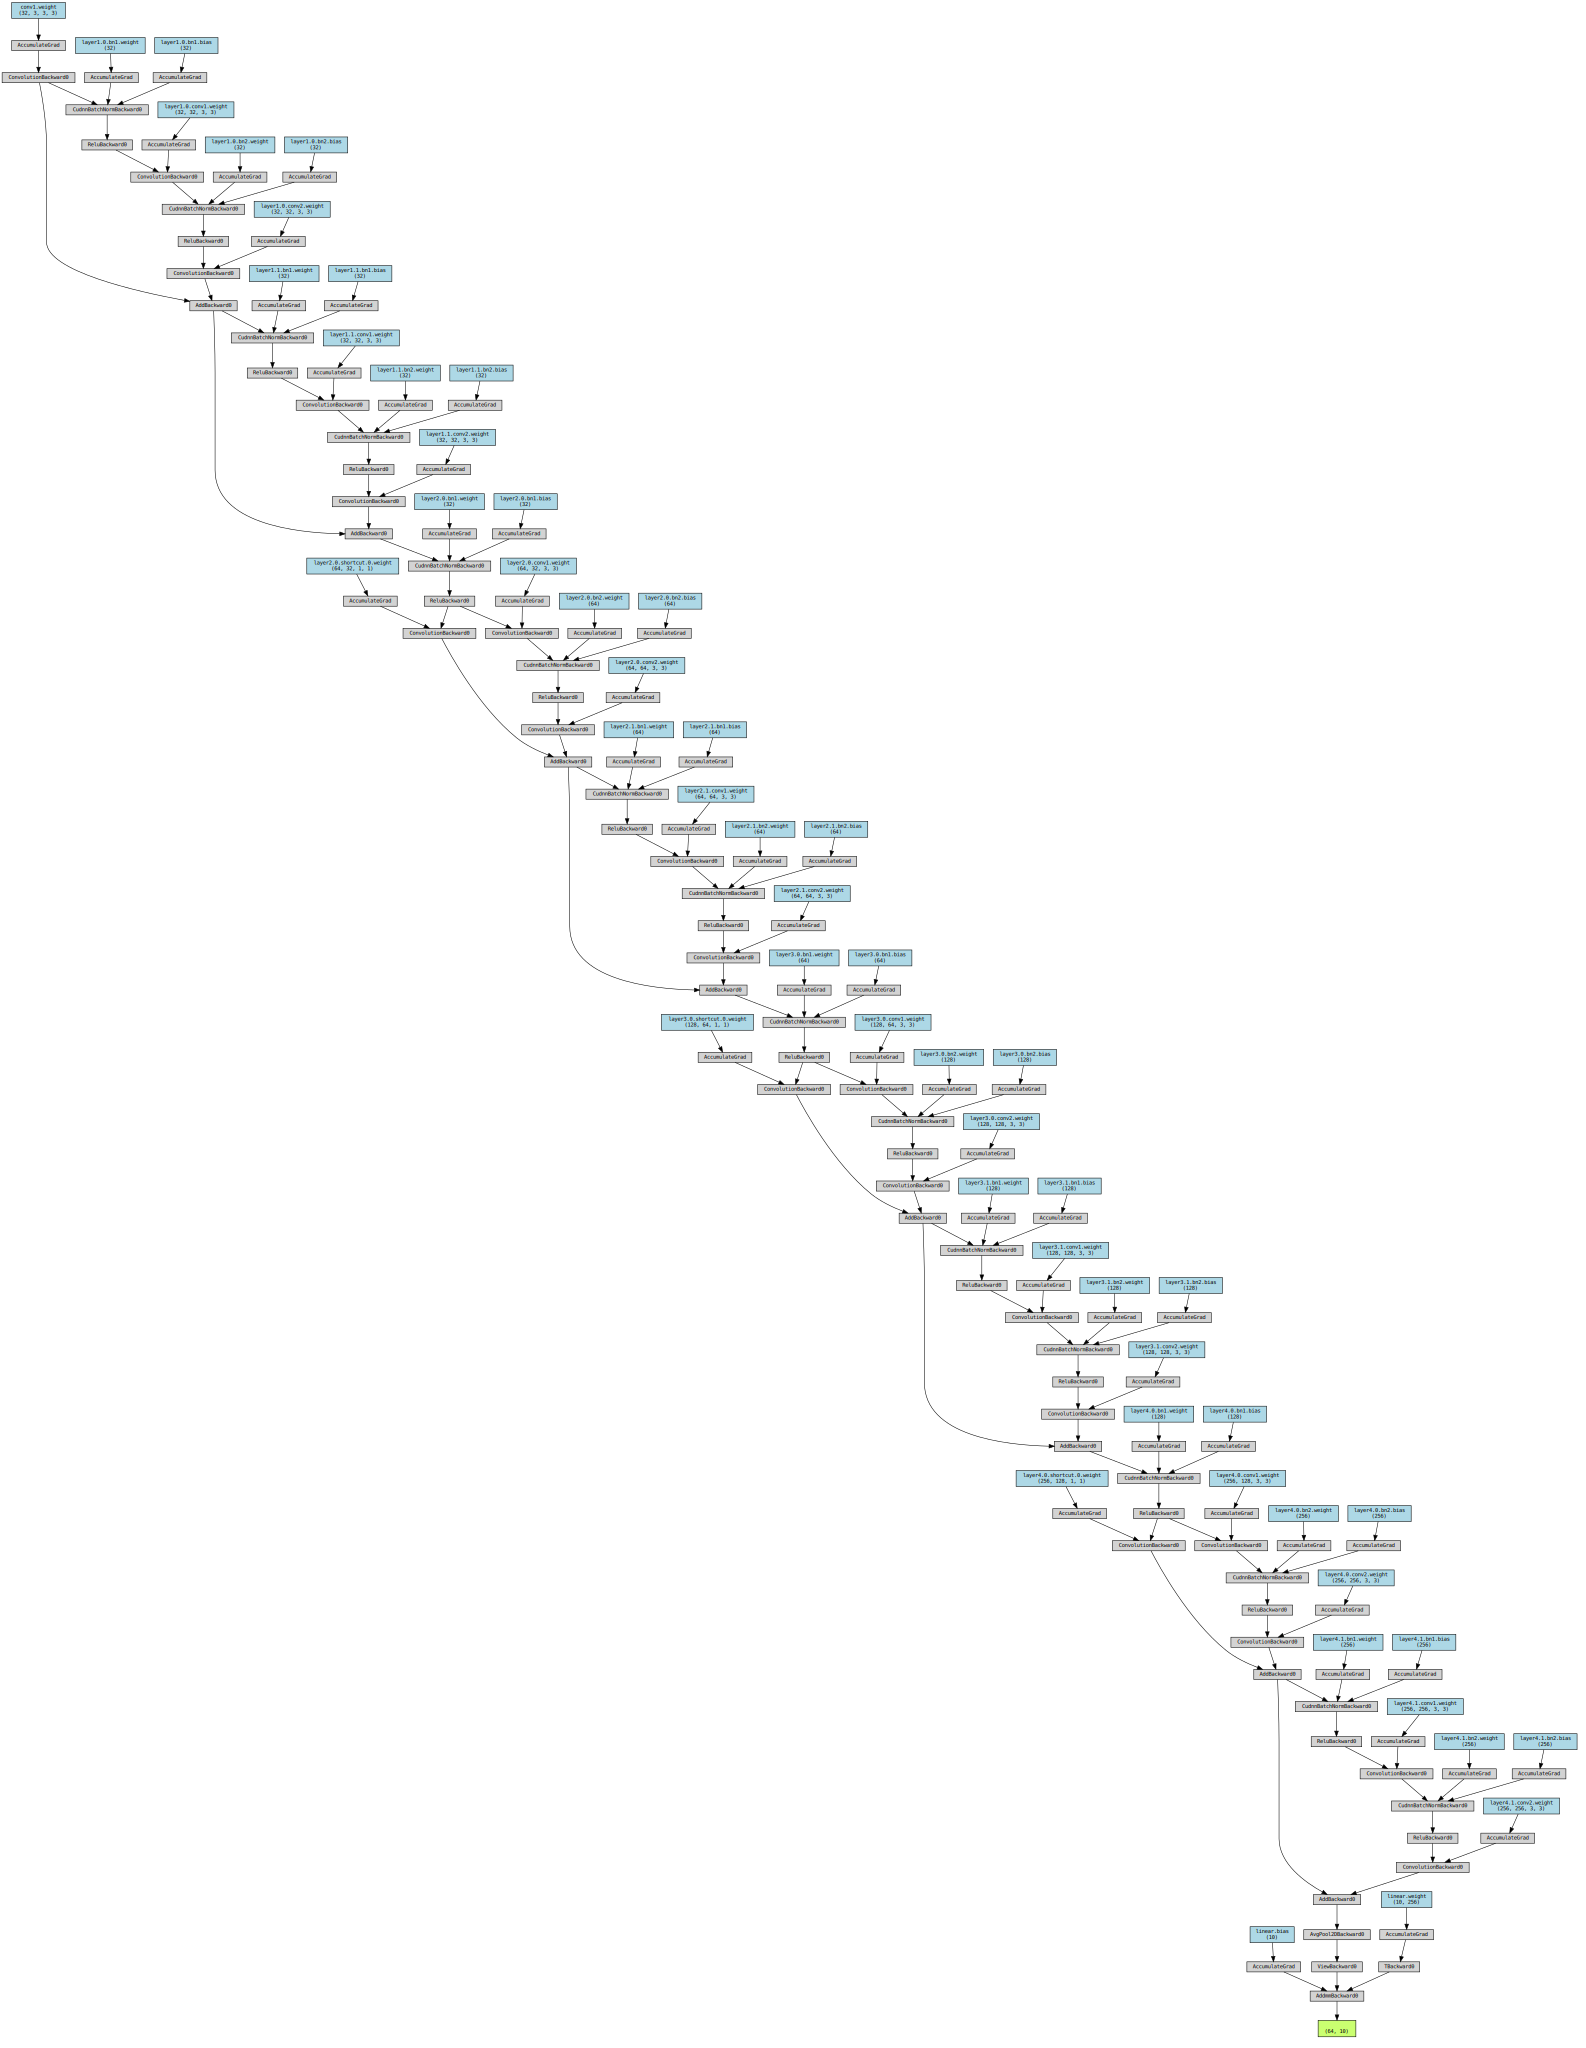

In [ ]:
from torchviz import make_dot

batch = next(iter(train_loader))
yhat = net(batch[0].to(device))
make_dot(yhat, params=dict(net.named_parameters()))

### Plotting the Confusion Matrix

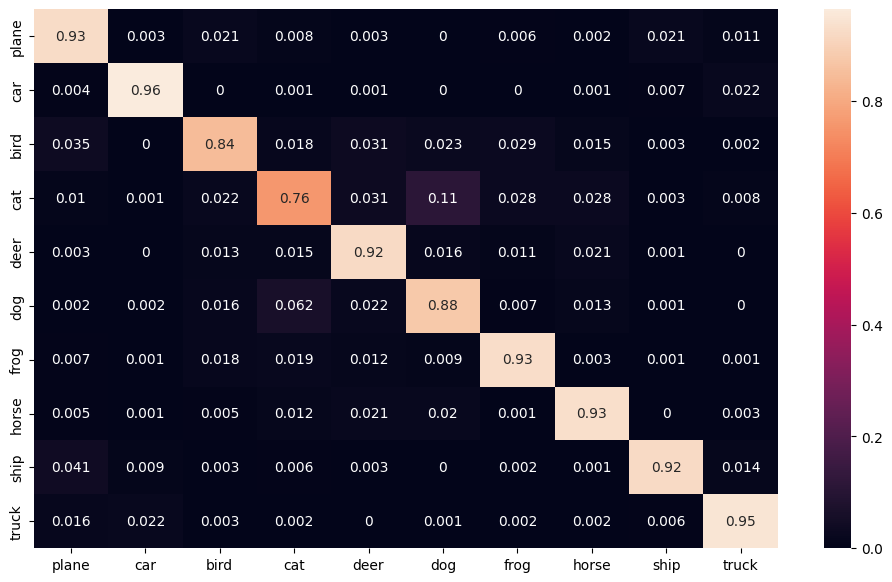

In [ ]:
cm = confusion_matrix(y_true, y_pred)
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')
df_cm = pd.DataFrame(cm / np.sum(cm, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')